In [32]:
import tensorflow as tf
import string
import numpy as np

In [33]:
### 使用CBOW, 用周围词预测当前词来学习词向量，使用该词左边的一个和右边的一个,并使用h
X_in_c = tf.placeholder(tf.int32,shape = [1,2])
y_out_c = tf.placeholder(tf.int32)
W1_c = tf.Variable(tf.random_normal((26,10),stddev = 1))

In [34]:
lookup_c = tf.nn.embedding_lookup(W1_c,X_in_c)
lookup_c = tf.reduce_mean(lookup_c,1) # 在那个维度进行求平均处理

In [35]:
class Node:
    def __init__(self,id,leaf_num, is_leaf):
        self.id = id 
#         if not is_leaf:
#             self.w = np.random.normal(size = (1,10))
        self.leaf_num = leaf_num
        self.is_leaf = is_leaf
        self.bel = []
        
    def add(self,leaf):
        self.bel.append(leaf)

In [36]:
### CBOW的Hierarchical Softmax
path = [[]for i in range(26)] ## 存放的是路径
V = []
for i in range(26):
    V.append(Node(-1,i,True))
id = 0
while len(V) > 1:
    V_tmp = []
    for i in range(0,len(V),2):
        if i + 1 == len(V):
            break
        node = Node(id,-1,False)
        if V[i].is_leaf: ## 叶子节点
            node.bel.append(V[i].leaf_num)
            path[V[i].leaf_num].append(node.id)
#             path[V[i].leaf_num].append(node)
        if V[i + 1].is_leaf:
            node.bel.append(V[i + 1].leaf_num)
            path[V[i + 1].leaf_num].append(-node.id)
#             path[V[i + 1].leaf_num].append(node)
            
        if not V[i].is_leaf:
            for v in V[i].bel:
                node.bel.append(v)
                path[v].append(node.id)
#                 path[v].append(node)
        if not V[i + 1].is_leaf:
            for v in V[i + 1].bel:
                node.bel.append(v)
                path[v].append(-node.id)
#                 path[v].append(node)
        V_tmp.append(node)
        id += 1
    if len(V) % 2 == 1:
        V_tmp.append(V[len(V) - 1])
    V = V_tmp

In [37]:
W2_hs = tf.Variable(tf.random_normal((25,10),stddev = 1))
path_normal = path[:-2]
path_other = path[-2:]
# path_normal,path_other

In [38]:
path_normal = tf.convert_to_tensor(path_normal,tf.int32)
path_other = tf.convert_to_tensor(path_other,tf.int32)
constant = tf.constant(24)
zero = tf.constant(0)
five = tf.constant(5)
three = tf.constant(3)


In [39]:
def cond1(i,loss):
    return i < five
def body1(i,loss):
    v = path_normal[y_out_c][i]
    
    def f5():
        return -tf.nn.embedding_lookup(W2_hs,tf.subtract(zero,v))
    def f6():
        return tf.nn.embedding_lookup(W2_hs,v)
    
    lookup = tf.cond(tf.less(v,zero),f5,f6)
    
    loss = tf.add(loss,- tf.log(tf.sigmoid(tf.matmul(lookup_c,tf.reshape(lookup,[10 ,1])))))
    return i + 1, loss

def cond2(i,loss):
    return i < three

def body2(i,loss):
    v = path_other[y_out_c - 24][i]
    def f3():
        return -tf.nn.embedding_lookup(W2_hs,tf.subtract(zero,v))
    def f4():
        return tf.nn.embedding_lookup(W2_hs,v)
    
    lookup = tf.cond(tf.less(v,zero),f3,f4)
    loss = tf.add(loss,- tf.log(tf.sigmoid(tf.matmul(lookup_c,tf.reshape(lookup,[10 ,1])))))
    return i + 1, loss 

In [47]:
def f1():
    loss = tf.Variable(0,dtype = tf.float32)
    loss = tf.reshape(loss,[1,1])
    _,loss =  tf.while_loop(cond1,body1,(0,loss))
    return loss

def f2():
    loss = tf.Variable(0,dtype = tf.float32)
    loss = tf.reshape(loss,[1,1])
    _,loss =  tf.while_loop(cond2,body2,(0,loss))
    return loss

r = tf.cond(tf.less(y_out_c , constant), f1, f2)

op = tf.train.GradientDescentOptimizer(0.001).minimize(r)

In [54]:
loss_list = []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(10000):
        feed_x = i % 26
        if feed_x == 0 or feed_x == 25:
            continue
        x_in_tmp = np.array([feed_x - 1,feed_x + 1]).reshape(1,2)
        result,_ = sess.run([r,op],feed_dict = {X_in_c :x_in_tmp ,y_out_c : feed_x
                                               })
        loss_list.append(result[0][0])

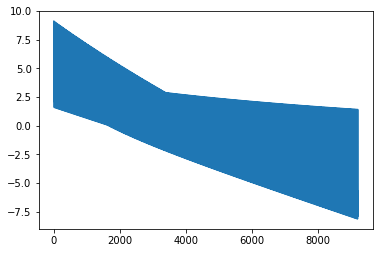

In [55]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_list)),loss_list)